# **Exercise 1: Simple RNN Sequence Length Experiment**

This Excersie demonstrates how different sequence lengths affect Simple RNN performance for weather prediction.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(" EXERCISE 1: SEQUENCE LENGTH EXPERIMENT")
print("=" * 60)
print("Goal: Understand how sequence length affects Simple RNN performance")
print("We'll test sequence lengths: 3, 5, 7, 10 days")
print("=" * 60)

 EXERCISE 1: SEQUENCE LENGTH EXPERIMENT
Goal: Understand how sequence length affects Simple RNN performance
We'll test sequence lengths: 3, 5, 7, 10 days


**Data Generation Function**

Creates fake weather data that looks real, with seasons, daily changes, and related values like temperature, humidity, pressure, and wind speed. This simulates real-world weather data for our experiments.

In [2]:
def generate_weather_data(days=500):
    """Generate synthetic weather data with realistic patterns"""
    np.random.seed(42)
    data = []

    for i in range(days):
        # Season calculation (0: spring, 1: summer, 2: fall, 3: winter)
        season = int(i / 91) % 4

        # Base temperature by season
        base_temps = [15, 25, 10, 0]  # Spring, Summer, Fall, Winter
        base_temp = base_temps[season]

        # Add seasonal and daily variations
        seasonal_variation = 5 * np.sin(2 * np.pi * i / 365)
        daily_variation = 3 * np.sin(2 * np.pi * i / 30)  # Monthly cycle
        random_variation = np.random.normal(0, 2)

        temperature = base_temp + seasonal_variation + daily_variation + random_variation

        # Correlated weather variables
        humidity = np.clip(60 + (25 - temperature) * 0.8 + np.random.normal(0, 5), 0, 100)
        pressure = 1013 + np.random.normal(0, 15) + temperature * 0.1
        wind_speed = np.clip(8 + np.random.exponential(5) + abs(temperature - 15) * 0.1, 0, 30)

        data.append({
            'Day': i,
            'Temperature': temperature,
            'Humidity': humidity,
            'Pressure': pressure,
            'WindSpeed': wind_speed,
            'Season': season
        })

    return pd.DataFrame(data)

**Data Preparation Function**

Purpose: Transforms raw weather data into sequences suitable for RNN training.

 Key steps include:

- Normalizing features to 0-1 range for better training
- Creating sliding windows of historical data (sequence_length days)
- Each sequence predicts the next day's target variable

In [3]:
def prepare_data_for_simple_rnn(data, sequence_length=7, feature_columns=None, target_column='Temperature'):
    """
    🔧 KEY FUNCTION: Prepare data for Simple RNN training
    This is where we modify sequence_length for Exercise 1
    """
    if feature_columns is None:
        feature_columns = ['Temperature', 'Humidity', 'Pressure', 'WindSpeed']

    print(f" Preparing data with sequence_length={sequence_length}")
    print(f" Features: {feature_columns}")
    print(f" Target: {target_column}")

    # Extract features and target
    features = data[feature_columns].values
    target = data[target_column].values.reshape(-1, 1)

    # Normalize data
    scaler_features = MinMaxScaler()
    scaler_target = MinMaxScaler()

    features_scaled = scaler_features.fit_transform(features)
    target_scaled = scaler_target.fit_transform(target)

    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(features_scaled)):
        X.append(features_scaled[i-sequence_length:i])
        y.append(target_scaled[i])

    X = np.array(X)
    y = np.array(y)

    print(f" Data shape: X={X.shape}, y={y.shape}")
    print(f" Available samples: {len(X)}")

    return X, y, scaler_features, scaler_target

**Model Creation Function**

Purpose: Defines the Simple RNN architecture with:

- SimpleRNN layer with tanh activation
- Dropout layer to prevent overfitting
- Dense layers for final prediction
- Mean Squared Error loss for regression

In [4]:
def create_simple_rnn_model(input_shape, hidden_units=32):
    """Create Simple RNN model"""
    print(f" Creating Simple RNN model:")
    print(f"   - Input shape: {input_shape}")
    print(f"   - Hidden units: {hidden_units}")

    model = Sequential([
        SimpleRNN(hidden_units,
                 input_shape=input_shape,
                 activation='tanh',
                 return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

**Training and Evaluation Function**

Purpose: Handles the complete training pipeline:

- Splits data into train/test sets (maintaining time order)
- Trains the model with validation
- Makes predictions and converts back to original scale
- Calculates performance metrics (MAE, RMSE)

In [5]:
def train_and_evaluate_model(X, y, scaler_target, sequence_length, hidden_units=32, epochs=30):
    """Train model and return performance metrics"""

    # Split data (80% train, 20% test)
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    print(f" Train samples: {len(X_train)}, Test samples: {len(X_test)}")

    # Create and train model
    model = create_simple_rnn_model(input_shape=(X.shape[1], X.shape[2]), hidden_units=hidden_units)

    print(f" Training model for {epochs} epochs...")
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_split=0.2,
        verbose=0,  # Reduced verbosity
        shuffle=False  # Keep time series order
    )

    # Make predictions
    predictions_scaled = model.predict(X_test, verbose=0)
    predictions = scaler_target.inverse_transform(predictions_scaled)
    y_test_denorm = scaler_target.inverse_transform(y_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test_denorm, predictions)
    rmse = np.sqrt(mean_squared_error(y_test_denorm, predictions))

    print(f"✅ Model Performance:")
    print(f"    Mean Absolute Error: {mae:.3f}")
    print(f"    Root Mean Square Error: {rmse:.3f}")

    return mae, rmse, history, predictions, y_test_denorm

**Generate Weather Data**

Purpose: Creates synthetic weather dataset and displays basic statistics to understand the data distribution and characteristics.

In [6]:
# Generate weather data
print("------- Generating synthetic weather data...")
weather_data = generate_weather_data(500)
print(f" Generated {len(weather_data)} days of weather data")
print("\n First 5 rows:")
print(weather_data.head())
print(f"\n Data statistics:")
print(weather_data.describe())

------- Generating synthetic weather data...
 Generated 500 days of weather data

 First 5 rows:
   Day  Temperature   Humidity     Pressure  WindSpeed  Season
0    0    15.993428  66.513936  1024.314671   8.947467       0
1    1    18.755862  66.390517  1030.033315  14.531836       0
2    2    15.453369  70.350105  1007.594072   9.859106       0
3    3    16.089995  54.065259  1028.864545   9.830114       0
4    4    15.547784  69.133009  1000.934417  11.099452       0

 Data statistics:
              Day  Temperature    Humidity     Pressure   WindSpeed  \
count  500.000000   500.000000  500.000000   500.000000  500.000000   
mean   249.500000    15.055008   67.919558  1015.683508   14.076156   
std    144.481833    11.784938   10.566244    14.550430    4.799837   
min      0.000000    -9.741175   43.684998   974.730568    8.150712   
25%    124.750000     5.660008   60.343514  1006.119876   10.330482   
50%    249.500000    17.290923   66.789206  1015.559626   12.883804   
75%    37

**Main Experiment Loop**

Main experiment that tests different sequence lengths (3, 5, 7, 10 days) and saves the results. This helps us see how changing the sequence length affects the model’s performance.

In [7]:
# Exercise 1: Test different sequence lengths
sequence_lengths = [3, 5, 7, 10]
results = {}

print(f"\n TESTING DIFFERENT SEQUENCE LENGTHS")
print("=" * 50)

for seq_len in sequence_lengths:
    print(f"\n TESTING SEQUENCE LENGTH: {seq_len}")
    print("-" * 40)

    # Prepare data with current sequence length
    X, y, scaler_features, scaler_target = prepare_data_for_simple_rnn(
        weather_data,
        sequence_length=seq_len,
        feature_columns=['Temperature', 'Humidity', 'Pressure', 'WindSpeed']
    )

    # Train and evaluate
    mae, rmse, history, predictions, actual = train_and_evaluate_model(
        X, y, scaler_target, seq_len, epochs=30
    )

    # Store results
    results[seq_len] = {
        'mae': mae,
        'rmse': rmse,
        'history': history,
        'predictions': predictions[:50],  # Store first 50 predictions for plotting
        'actual': actual[:50]
    }

    print(f"✅ Completed sequence length {seq_len}")


 TESTING DIFFERENT SEQUENCE LENGTHS

 TESTING SEQUENCE LENGTH: 3
----------------------------------------
 Preparing data with sequence_length=3
 Features: ['Temperature', 'Humidity', 'Pressure', 'WindSpeed']
 Target: Temperature
 Data shape: X=(497, 3, 4), y=(497, 1)
 Available samples: 497
 Train samples: 397, Test samples: 100
 Creating Simple RNN model:
   - Input shape: (3, 4)
   - Hidden units: 32
 Training model for 30 epochs...
✅ Model Performance:
    Mean Absolute Error: 2.513
    Root Mean Square Error: 3.422
✅ Completed sequence length 3

 TESTING SEQUENCE LENGTH: 5
----------------------------------------
 Preparing data with sequence_length=5
 Features: ['Temperature', 'Humidity', 'Pressure', 'WindSpeed']
 Target: Temperature
 Data shape: X=(495, 5, 4), y=(495, 1)
 Available samples: 495
 Train samples: 396, Test samples: 99
 Creating Simple RNN model:
   - Input shape: (5, 4)
   - Hidden units: 32
 Training model for 30 epochs...
✅ Model Performance:
    Mean Absolute E

✅ Model Performance:
    Mean Absolute Error: 3.277
    Root Mean Square Error: 4.188
✅ Completed sequence length 7

 TESTING SEQUENCE LENGTH: 10
----------------------------------------
 Preparing data with sequence_length=10
 Features: ['Temperature', 'Humidity', 'Pressure', 'WindSpeed']
 Target: Temperature
 Data shape: X=(490, 10, 4), y=(490, 1)
 Available samples: 490
 Train samples: 392, Test samples: 98
 Creating Simple RNN model:
   - Input shape: (10, 4)
   - Hidden units: 32
 Training model for 30 epochs...
✅ Model Performance:
    Mean Absolute Error: 3.070
    Root Mean Square Error: 4.050
✅ Completed sequence length 10


**Results Comparison Table**

Purpose: Creates a formatted table comparing the performance of different sequence lengths, showing MAE, RMSE, and percentage improvement relative to the baseline.

In [8]:
# Compare results
print("\n" + "=" * 60)
print("📊 EXERCISE 1 RESULTS: SEQUENCE LENGTH COMPARISON")
print("=" * 60)

print(f"{'Sequence Length':<15} {'MAE':<10} {'RMSE':<10} {'Improvement':<12}")
print("-" * 50)

base_mae = None
for seq_len, metrics in results.items():
    if base_mae is None:
        base_mae = metrics['mae']
        improvement = "Baseline"
    else:
        improvement = f"{((base_mae - metrics['mae']) / base_mae * 100):+.1f}%"

    print(f"{seq_len:<15} {metrics['mae']:<10.3f} {metrics['rmse']:<10.3f} {improvement:<12}")


📊 EXERCISE 1 RESULTS: SEQUENCE LENGTH COMPARISON
Sequence Length MAE        RMSE       Improvement 
--------------------------------------------------
3               2.513      3.422      Baseline    
5               2.570      3.396      -2.3%       
7               3.277      4.188      -30.4%      
10              3.070      4.050      -22.2%      


**Visualization**

Purpose: Creates comprehensive visualizations showing:

- MAE comparison across sequence lengths
- RMSE comparison across sequence lengths
- Training history for the best performing model
- Actual vs predicted values for the best model

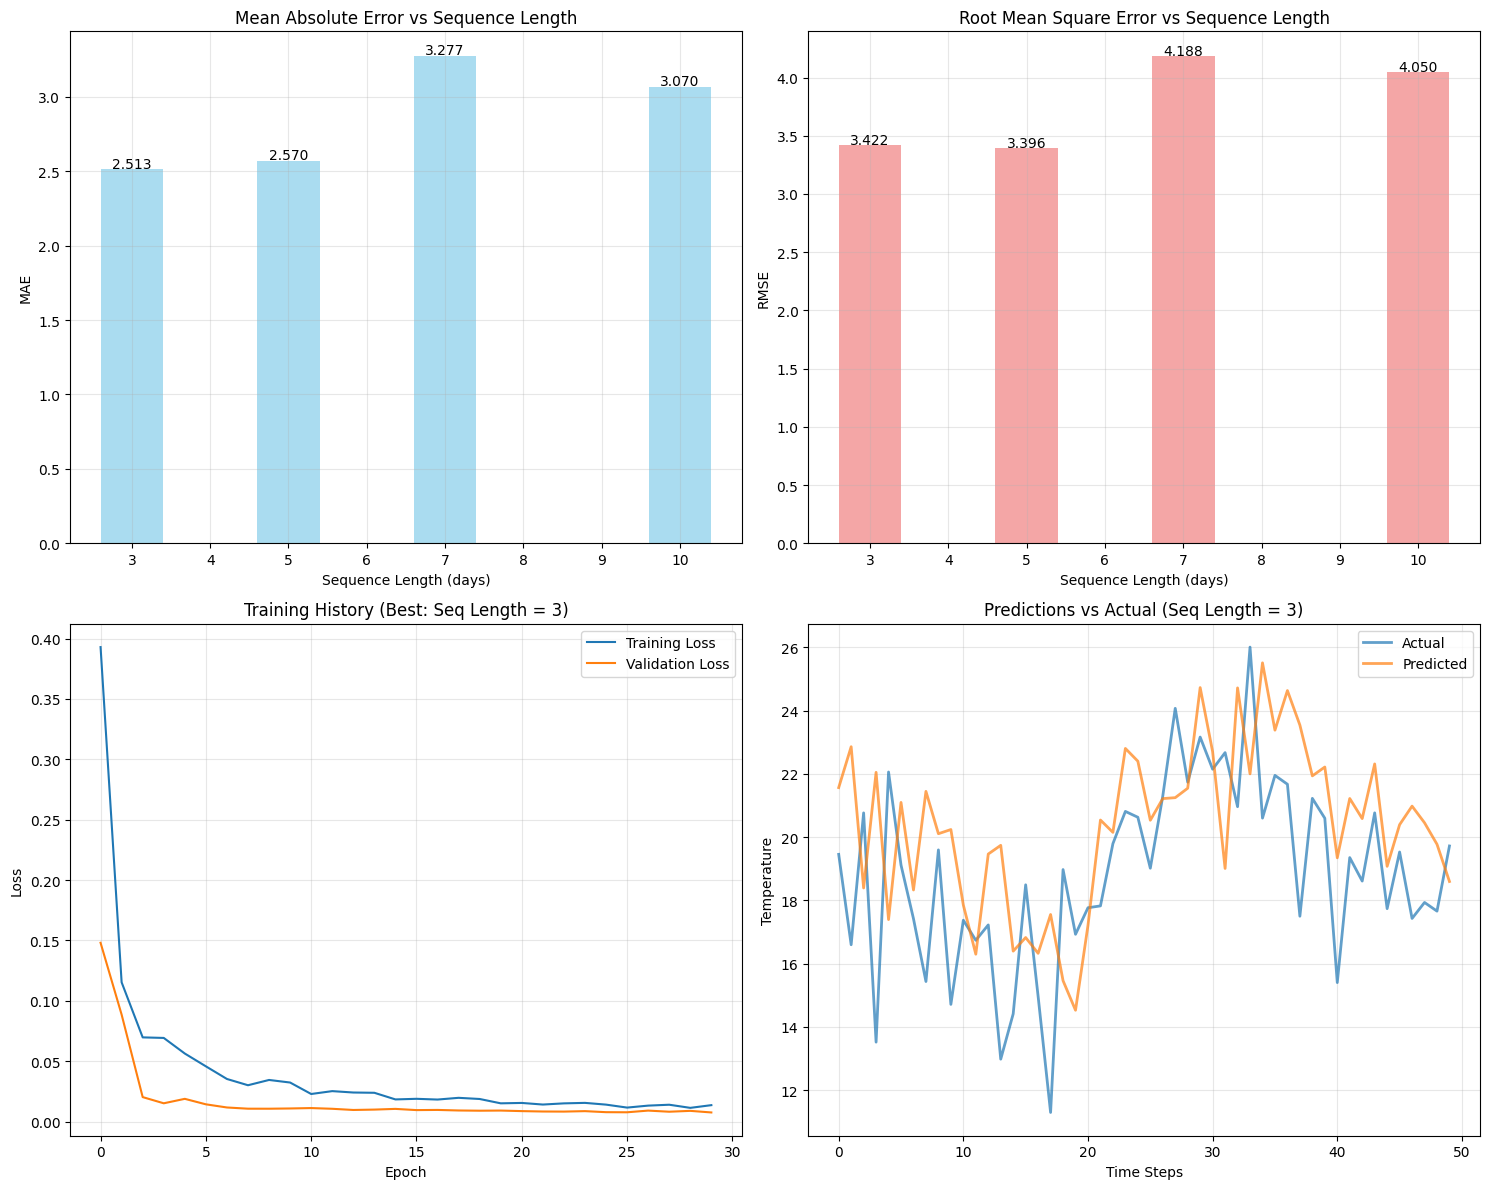

In [9]:
# Plot results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: MAE comparison
sequence_lens = list(results.keys())
maes = [results[seq_len]['mae'] for seq_len in sequence_lens]
rmses = [results[seq_len]['rmse'] for seq_len in sequence_lens]

ax1.bar(sequence_lens, maes, color='skyblue', alpha=0.7)
ax1.set_title('Mean Absolute Error vs Sequence Length')
ax1.set_xlabel('Sequence Length (days)')
ax1.set_ylabel('MAE')
ax1.grid(True, alpha=0.3)
for i, v in enumerate(maes):
    ax1.text(sequence_lens[i], v + 0.01, f'{v:.3f}', ha='center')

# Plot 2: RMSE comparison
ax2.bar(sequence_lens, rmses, color='lightcoral', alpha=0.7)
ax2.set_title('Root Mean Square Error vs Sequence Length')
ax2.set_xlabel('Sequence Length (days)')
ax2.set_ylabel('RMSE')
ax2.grid(True, alpha=0.3)
for i, v in enumerate(rmses):
    ax2.text(sequence_lens[i], v + 0.01, f'{v:.3f}', ha='center')

# Plot 3: Training history for best sequence length
best_seq_len = min(results.keys(), key=lambda k: results[k]['mae'])
best_history = results[best_seq_len]['history']

ax3.plot(best_history.history['loss'], label='Training Loss')
ax3.plot(best_history.history['val_loss'], label='Validation Loss')
ax3.set_title(f'Training History (Best: Seq Length = {best_seq_len})')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Predictions vs Actual for best sequence length
ax4.plot(results[best_seq_len]['actual'], label='Actual', linewidth=2, alpha=0.7)
ax4.plot(results[best_seq_len]['predictions'], label='Predicted', linewidth=2, alpha=0.7)
ax4.set_title(f'Predictions vs Actual (Seq Length = {best_seq_len})')
ax4.set_xlabel('Time Steps')
ax4.set_ylabel('Temperature')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Analysis and Insights**

Purpose: Provides detailed analysis of the experimental results, identifying the best and worst performing sequence lengths, calculating improvements, and extracting key insights about sequence length selection in RNNs.

In [10]:
# Analysis and insights
print("\n" + "=" * 60)
print(" EXERCISE 1 ANALYSIS & INSIGHTS")
print("=" * 60)

best_seq_len = min(results.keys(), key=lambda k: results[k]['mae'])
worst_seq_len = max(results.keys(), key=lambda k: results[k]['mae'])

print(f"--- Best performing sequence length: {best_seq_len} days")
print(f"   - MAE: {results[best_seq_len]['mae']:.3f}")
print(f"   - RMSE: {results[best_seq_len]['rmse']:.3f}")

print(f"\n--- Worst performing sequence length: {worst_seq_len} days")
print(f"   - MAE: {results[worst_seq_len]['mae']:.3f}")
print(f"   - RMSE: {results[worst_seq_len]['rmse']:.3f}")

improvement = ((results[worst_seq_len]['mae'] - results[best_seq_len]['mae']) / results[worst_seq_len]['mae']) * 100
print(f"\n Performance improvement: {improvement:.1f}% (best vs worst)")


print(f"\n EXERCISE 1 COMPLETED!")



 EXERCISE 1 ANALYSIS & INSIGHTS
--- Best performing sequence length: 3 days
   - MAE: 2.513
   - RMSE: 3.422

--- Worst performing sequence length: 7 days
   - MAE: 3.277
   - RMSE: 4.188

 Performance improvement: 23.3% (best vs worst)

 EXERCISE 1 COMPLETED!
